## Kalman filter
#### Load video use object detection and apply Kalman filter

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import selectivesearch

## Kalman for 2D case

In [ ]:
def update(x, P, Z, H, R):
    y = Z - H @ x
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x_prime = x + K @ y
    I = np.eye(x.shape[0])
    P_prime = (I - K @ H) @ P
    return x_prime, P_prime

def predict(x, P, F, u):
    x_prime = F @ x + u
    P_prime = F @ P @ F.T
    return x_prime, P_prime

# Initialize Kalman filter parameters
dt = 1  # Adjust the time step as needed

# State vector: [x_position, x_velocity, x_acceleration, y_position, y_velocity, y_acceleration]
x = np.array([[0],  # x position
              [0],  # x velocity
              [0],  # x acceleration
              [0],  # y position
              [0],  # y velocity
              [0]]) # y acceleration

P = np.eye(6) * 1000  # Initial uncertainty
u = np.zeros((6, 1))  # External motion

# State transition matrix for constant acceleration
F = np.array([
    [1, dt, 0.5 * dt**2, 0,  0,         0],
    [0,  1,       dt,    0,  0,         0],
    [0,  0,        1,    0,  0,         0],
    [0,  0,        0,    1, dt, 0.5 * dt**2],
    [0,  0,        0,    0,  1,        dt],
    [0,  0,        0,    0,  0,         1]
])

# Observation matrix mapping the state to the measurement space
H = np.array([
    [1, 0, 0, 0, 0, 0],  # x position measurement
    [0, 0, 0, 1, 0, 0]   # y position measurement
])

R = np.array([[1, 0],
              [0, 1]])  # Measurement uncertainty

def detect_red_ball(frame):
    hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array([2,100,100])
    upper_blue = np.array([10,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,hsv, mask= mask)
    # Taking a matrix of size 5 as the kernel 
    kernel = np.ones((5, 5), np.uint8) 
    
    
    img_erosion = cv2.erode(res, kernel, iterations=8) 
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=8) 
    # # Find blob contours on mask
    #print(img_dilation.shape)
    cnts = cv2.findContours(img_dilation[:,:,2], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # # take the first contour 
    
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]  # For compatibility with different OpenCV versions
    if len(cnts) > 0:
        # Take the largest contour
        largest_contour = max(cnts, key=cv2.contourArea)
        (x_axis, y_axis), radius = cv2.minEnclosingCircle(largest_contour)

        center = (int(x_axis), int(y_axis))
        radius = int(radius)

        # Draw a circle around the detected red ball
        if radius > 5:  # Only consider contours with a reasonable size
            cv2.circle(frame, center, radius, (0, 255, 0), 2)

        return {"img": frame, "center": center}

    return {"img": frame, "center": None}


def drawLocations(img, center, prediction):
    cv2.circle(img, center, 10, [0, 255, 0], 2)
    cv2.circle(img, prediction, 80, [255, 0, 0], 2)
    return img

# Load the video
cap = cv2.VideoCapture('rolling_ball.mp4')
if not cap.isOpened():
    print("Cannot open video")
    exit()

count = 50
# Looping through all the frames
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect the ball
    imageAndCenter = detect_red_ball(frame)
    res = imageAndCenter["img"]
    if imageAndCenter["center"]:
        center = imageAndCenter["center"]

        # Update step
        xc, yc = center
        z = np.array([[xc], [yc]])  # Measurement vector
        x, P = update(x, P, z, H, R)

        # Predict the next state
        x, P = predict(x, P, F, u)

        # Draw the current tracked state and the predicted state on the image frame
        prediction = (int(x[0][0]), int(x[3][0]))
        res = drawLocations(res, center, prediction)
    elif x.all() != None and P.all()!= None:
        # Predict the next state
        x, P = predict(x, P, F, u)
        prediction = (int(x[0][0]), int(x[3][0]))
        res = drawLocations(res, (0,0), prediction)
    cv2.imshow('Frame', res)
    cv2.waitKey(50)
    if count == 0:
        break
    count -= 1
cap.release()
cv2.destroyAllWindows()



## Kalman filter for project

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

seq_01 = load_images_from_folder("../34759_final_project_rect/seq_02/image_02/data")


In [13]:
for image in seq_01:
    cv2.imshow('Frame', image)
    cv2.waitKey(50)

In [15]:
img = cv2.imread("../34759_final_project_rect/seq_02/image_03/data/0000000000.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
guy = img[160:255,415:455]

In [44]:
# Load the image
img = cv2.imread("../34759_final_project_rect/seq_02/image_03/data/0000000000.png")

# Get selective search object proposals
proposals = selectivesearch.selective_search(img,min_size=200)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


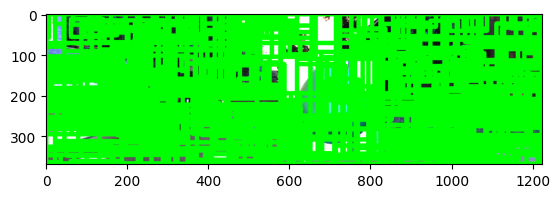

In [46]:

# Draw the proposals on the image
output_image = img.copy()

rects = [proposal['rect'] for proposal in proposals[1]]
for x, y, w, h in rects:
	cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 10)

# Display the result 
plt.imshow(output_image)
plt.show()


In [59]:
def opticalFlow(first_frame,second_frame):
    gray1 = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)

    feat1 = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.3, minDistance=7)
    feat2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, feat1, None)
    for i in range(len(feat1)):
        f10=int(feat1[i][0][0])
        f11=int(feat1[i][0][1])
        f20=int(feat2[i][0][0])
        f21=int(feat2[i][0][1])
        dist = np.sqrt((f20-f10)**2 +(f21-f11)**2 )
        if dist > 100:
            cv2.line(second_frame, (f10,f11), (f20, f21), (0, 255, 0), 2)
            cv2.circle(second_frame, (f10, f11), 5, (0, 255, 0), -1)


    return second_frame, feat1



first_frame = seq_01[0]
for second_frame in seq_01:
    image,feat1 = opticalFlow(first_frame=second_frame,second_frame=first_frame)
    
    cv2.imshow('image', image)
    cv2.waitKey(20)
    first_frame = second_frame



In [21]:
gauss_seq_01 = [cv2.GaussianBlur(image, (11, 11), 0) for image in seq_01]

In [35]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import collections
seq_01 = load_images_from_folder("../34759_final_project_rect/seq_02/image_02/data")
def opticalFlowCluster(first_frame, second_frame):
    gray1 = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)

    feat1 = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.3, minDistance=7)
    feat2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, feat1, None)

    # Reshape feature arrays for easier processing
    feat1_positions = feat1.reshape(-1, 2)
    feat2_positions = feat2.reshape(-1, 2)

    # Compute distances between original and new positions
    distances = np.linalg.norm(feat2_positions - feat1_positions, axis=1)

    # Debugging: Print the maximum and average distances
    print(f"Max distance: {distances.max()}, Average distance: {distances.mean()}")

    # Threshold for significant movement (adjusted based on standard deviation)
    threshold = distances.mean() #+ distances.std()
    print(f"Movement threshold set to: {threshold}")

    significant_movement_indices = np.where(distances > threshold)[0]

    # Get features with significant movement
    significant_feat1 = feat1_positions[significant_movement_indices]
    significant_feat2 = feat2_positions[significant_movement_indices]

    # Check if there are any significant features
    print(f"Number of significant features: {significant_feat1.shape[0]}")

    if significant_feat1.shape[0] > 0:
        # Cluster the significant features
        # Estimate a suitable epsilon based on distances between features
        # For example, let's set epsilon to 30 pixels
        epsilon = 300  # Adjust this value based on your data
        print(f"Clustering with epsilon: {epsilon}")

        clustering = DBSCAN(eps=epsilon, min_samples=1).fit(significant_feat1)
        labels = clustering.labels_

        # Unique labels and number of clusters
        unique_labels = set(labels)
        n_clusters = len(unique_labels)
        print(f"Number of clusters formed: {n_clusters}")
        print(f"Cluster labels: {unique_labels}")

        # Group features by cluster label
        clusters = collections.defaultdict(list)
        for idx, label in enumerate(labels):
            clusters[label].append(idx)

        # Draw lines and circles for each cluster centroid
        print(f"Drawing {len(clusters.keys())} points on the image.")
        for label in clusters.keys():
            indices = clusters[label]
            cluster_feat1_positions = significant_feat1[indices]
            cluster_feat2_positions = significant_feat2[indices]
            centroid_feat1 = np.mean(cluster_feat1_positions, axis=0).astype(int)
            centroid_feat2 = np.mean(cluster_feat2_positions, axis=0).astype(int)
            

            cv2.line(second_frame, tuple(centroid_feat1), tuple(centroid_feat2), (0, 255, 0), 2)
            #cv2.circle(second_frame, tuple(centroid_feat1), 40, (0, 255, 0), 2)
            upper_left = (centroid_feat1[0]-20, centroid_feat1[1]+50)
            lower_right = (centroid_feat1[0]+20, centroid_feat1[1]-50)
            cv2.rectangle(second_frame, upper_left, lower_right, (0, 0, 255), 2)            

            
    else:
        print("No significant movements detected in this frame.")

    return second_frame, feat1

# Corrected main loop
first_frame = seq_01[0]
for second_frame in seq_01[1:]:
    image, feat1 = opticalFlowCluster(first_frame=first_frame, second_frame=second_frame)
    cv2.imshow('image', image)
    cv2.waitKey(20)
    first_frame = second_frame


Max distance: 21.37064552307129, Average distance: 2.1477556228637695
Movement threshold set to: 2.1477556228637695
Number of significant features: 14
Clustering with epsilon: 300
Number of clusters formed: 1
Cluster labels: {0}
Drawing 1 points on the image.
Max distance: 22.909345626831055, Average distance: 2.7723004817962646
Movement threshold set to: 2.7723004817962646
Number of significant features: 15
Clustering with epsilon: 300
Number of clusters formed: 1
Cluster labels: {0}
Drawing 1 points on the image.
Max distance: 25.638078689575195, Average distance: 2.4785547256469727
Movement threshold set to: 2.4785547256469727
Number of significant features: 12
Clustering with epsilon: 300
Number of clusters formed: 1
Cluster labels: {0}
Drawing 1 points on the image.
Max distance: 169.79551696777344, Average distance: 5.241375923156738
Movement threshold set to: 5.241375923156738
Number of significant features: 15
Clustering with epsilon: 300
Number of clusters formed: 1
Cluster la

## Use of YOLO

In [4]:
import cv2
from ultralytics import YOLO


In [64]:
class KalmanBoundingBoxTracker:
    count = 0
    def __init__(self, bbox):
        x1, y1, x2, y2 = bbox
        self.w = x2 - x1
        self.h = y2 - y1
        center_x = x1 + self.w / 2.
        center_y = y1 + self.h / 2.

        # State vector: [x_position, x_velocity, x_acceleration, y_position, y_velocity, y_acceleration, width, height]
        self.x = np.array([[center_x], [0], [0], [center_y], [0], [0], [self.w], [self.h]])

        # State covariance matrix
        self.P = np.eye(8) * 1000
        self.P[6,6] = 10  # Lower uncertainty in initial width
        self.P[7,7] = 10  # Lower uncertainty in initial height

        # Time step
        dt = 1

        # State transition matrix for constant acceleration model with constant size
        self.F = np.array([
            [1, dt, 0.5 * dt**2, 0,  0,          0,  0,  0],
            [0, 1,  dt,          0,  0,          0,  0,  0],
            [0, 0,  1,           0,  0,          0,  0,  0],
            [0, 0,  0,           1, dt, 0.5 * dt**2, 0,  0],
            [0, 0,  0,           0, 1,  dt,          0,  0],
            [0, 0,  0,           0, 0,  1,           0,  0],
            [0, 0,  0,           0, 0,  0,           1,  0],
            [0, 0,  0,           0, 0,  0,           0,  1]
        ])

        # Observation matrix (we can observe positions and sizes)
        self.H = np.array([
            [1, 0, 0, 0, 0, 0, 0, 0],  # Measure x_position
            [0, 0, 0, 1, 0, 0, 0, 0],  # Measure y_position
            [0, 0, 0, 0, 0, 0, 1, 0],  # Measure width
            [0, 0, 0, 0, 0, 0, 0, 1]   # Measure height
        ])

        # Process noise covariance matrix
        q_pos = 0.1  # Adjust this value based on expected acceleration noise
        q_size = 0.01  # Adjust this value based on expected size change
        self.Q = np.zeros((8, 8))
        self.Q[0:6, 0:6] = q_pos * np.array([
            [dt**5/20, dt**4/8, dt**3/6, 0,          0,          0],
            [dt**4/8, dt**3/3, dt**2/2, 0,          0,          0],
            [dt**3/6, dt**2/2, dt,      0,          0,          0],
            [0,       0,       0,       dt**5/20, dt**4/8, dt**3/6],
            [0,       0,       0,       dt**4/8, dt**3/3, dt**2/2],
            [0,       0,       0,       dt**3/6, dt**2/2, dt]
        ])
        self.Q[6:, 6:] = q_size * np.eye(2)

        # Measurement noise covariance matrix
        r_pos = 1  # Adjust this value based on measurement accuracy
        r_size = 1  # Adjust this value based on measurement accuracy
        self.R = np.diag([r_pos, r_pos, r_size, r_size])

        self.time_since_update = 0
        self.id = KalmanBoundingBoxTracker.count
        KalmanBoundingBoxTracker.count += 1

        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        self.time_since_update += 1
        self.age += 1
        self.history.append(self.x)
        return self.get_state()

    def update(self, bbox):
        self.time_since_update = 0
        self.hits += 1
        self.hit_streak += 1

        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        center_x = x1 + w / 2.
        center_y = y1 + h / 2.

        # Measurement vector includes position, width, and height
        self.Z = np.array([[center_x], [center_y], [w], [h]])

        y = self.Z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.F.shape[0]) - K @ self.H) @ self.P

        # Update width and height
        self.w = self.x[6][0]
        self.h = self.x[7][0]

    def get_state(self):
        x = self.x[0][0]
        y = self.x[3][0]
        w = self.x[6][0]
        h = self.x[7][0]
        x1 = x - w / 2.
        y1 = y - h / 2.
        x2 = x + w / 2.
        y2 = y + h / 2.
        return [x1, y1, x2, y2]


In [56]:
def iou(bb_test, bb_gt):
    """
    Computes IoU between two bounding boxes.
    """
    xx1 = np.maximum(bb_test[0], bb_gt[0])
    yy1 = np.maximum(bb_test[1], bb_gt[1])
    xx2 = np.minimum(bb_test[2], bb_gt[2])
    yy2 = np.minimum(bb_test[3], bb_gt[3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[2] - bb_test[0]) * (bb_test[3] - bb_test[1]) +
              (bb_gt[2] - bb_gt[0]) * (bb_gt[3] - bb_gt[1]) - wh)
    return o


In [65]:
from scipy.optimize import linear_sum_assignment
def linear_assignment(cost_matrix):
    """
    Solve the assignment problem using the Hungarian algorithm (also known as Munkres algorithm).
    """
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))

def associate_detections_to_trackers(detections, trackers, iou_threshold=0.3):
    """
    Assigns detections to tracked objects (both represented as bounding boxes).
    Returns 3 lists of matches, unmatched_detections, and unmatched_trackers.
    """
    if len(trackers) == 0:
        return np.empty((0, 2), dtype=int), np.arange(len(detections)), []

    iou_matrix = np.zeros((len(detections), len(trackers)), dtype=np.float32)

    for d, det in enumerate(detections):
        for t, trk in enumerate(trackers):
            iou_matrix[d, t] = iou(det, trk)

    matched_indices = linear_assignment(-iou_matrix)

    unmatched_detections = []
    for d in range(len(detections)):
        if d not in matched_indices[:, 0]:
            unmatched_detections.append(d)

    unmatched_trackers = []
    for t in range(len(trackers)):
        if t not in matched_indices[:, 1]:
            unmatched_trackers.append(t)

    # Filter out matches with low IoU
    matches = []
    for m in matched_indices:
        if iou_matrix[m[0], m[1]] < iou_threshold:
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1, 2))

    if len(matches) == 0:
        matches = np.empty((0, 2), dtype=int)
    else:
        matches = np.concatenate(matches, axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)


In [66]:
# Initialize the YOLO model
yolo = YOLO('yolov8s.pt')

# Load the sequence of images
seq_01 = load_images_from_folder("../34759_final_project_rect/seq_02/image_02/data")

# Function to get class colors (as before)
def getColours(id_num, is_prediction=False):
    # Use different colors for prediction and update
    np.random.seed(id_num)
    if is_prediction:
        colour = (255, 0, 0)  # Blue for predictions
    else:
        colour = (0, 255, 0)  # Green for updates
    return colour

# Initialize trackers list and parameters
trackers = []
max_age = 50     # Maximum number of frames to keep a tracker without updates
min_hits = 3    # Minimum number of hits to consider a tracker as confirmed
frame_count = 0

for frame in seq_01:
    frame_count += 1

    # Get detections from YOLO model
    results = yolo.predict(frame)
    detected_bounding_boxes = []

    # Process YOLO detections
    for result in results[:4]:
        # Get the class names
        classes_names = result.names

        # Iterate over each box
        for box in result.boxes:
            # Check if confidence is greater than 40 percent
            if box.conf[0] > 0.4:
                # Get coordinates
                x1, y1, x2, y2 = box.xyxy[0]
                # Convert to int
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # Get the class
                cls = int(box.cls[0])

                # Get the class name
                class_name = classes_names[cls]

                if class_name in ["person", "bicycle"]:
                    detected_bounding_boxes.append([x1, y1, x2, y2])

    # Convert trackers to bounding boxes and draw predictions
    trks = []
    to_del = []
    ret = []
    for t, trk in enumerate(trackers):
        pos = trk.predict()  # Get the predicted state
        if np.any(np.isnan(pos)):
            to_del.append(t)
            continue
        trks.append(pos)
        ret.append(pos + [trk.id])

        # Draw the predicted bounding box
        x1_pred, y1_pred, x2_pred, y2_pred = map(int, pos)
        colour = getColours(trk.id, is_prediction=True)
        cv2.rectangle(frame, (x1_pred, y1_pred), (x2_pred, y2_pred), colour, 2)
        cv2.putText(frame, f'Pred ID {trk.id}', (x1_pred, y1_pred - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, colour, 2)

    # Remove dead trackers
    for t in reversed(to_del):
        trackers.pop(t)
    trks = np.array(trks)

    # Associate detections to trackers
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(detected_bounding_boxes, trks)

    # Update matched trackers with assigned detections
    for m in matched:
        trackers[m[1]].update(detected_bounding_boxes[m[0]])

    # Create and initialize new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoundingBoxTracker(detected_bounding_boxes[i])
        trackers.append(trk)

    # Increase age and time_since_update for unmatched trackers
    for i in unmatched_trks:
        trk = trackers[i]
        trk.time_since_update += 1
        trk.hit_streak = 0

    # Remove dead trackers
    trackers = [trk for trk in trackers if trk.time_since_update <= max_age]

    # Draw the updated bounding boxes
    for trk in trackers:
        if trk.time_since_update == 0:
            bbox = trk.get_state()
            x1_upd, y1_upd, x2_upd, y2_upd = map(int, bbox)
            colour = getColours(trk.id, is_prediction=False)
            cv2.rectangle(frame, (x1_upd, y1_upd), (x2_upd, y2_upd), colour, 2)
            cv2.putText(frame, f'ID {trk.id}', (x1_upd, y1_upd - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, colour, 2)

    # Show the frame
    cv2.imshow('frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources and close windows
cv2.destroyAllWindows()



0: 224x640 7 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bench, 1 bird, 203.6ms
Speed: 7.4ms preprocess, 203.6ms inference, 5.5ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bird, 224.2ms
Speed: 15.8ms preprocess, 224.2ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 5 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 bird, 287.4ms
Speed: 2.7ms preprocess, 287.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 5 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bird, 375.5ms
Speed: 2.1ms preprocess, 375.5ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 5 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bird, 233.6ms
Speed: 2.0ms preprocess, 233.6ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 persons, 2 bicycles, 4 cars, 1 bird, 508.9ms
Speed: 2.5ms preprocess, 508.9ms inference, 1.5ms postprocess per image at shape

## Everything below does not work!

In [34]:
import numpy as np
import cv2
from ultralytics import YOLO
from scipy.optimize import linear_sum_assignment
import os

# KalmanBoundingBoxTracker Class
class KalmanBoundingBoxTracker:
    count = 0
    def __init__(self, bbox):
        x1, y1, x2, y2 = bbox
        self.w = x2 - x1
        self.h = y2 - y1
        center_x = x1 + self.w / 2.
        center_y = y1 + self.h / 2.

        # State vector: [x_position, x_velocity, x_acceleration, y_position, y_velocity, y_acceleration]
        self.x = np.array([[center_x], [0], [0], [center_y], [0], [0]])

        # State covariance matrix
        self.P = np.eye(6) * 1000

        # Time step
        dt = 1

        # State transition matrix for constant acceleration model
        self.F = np.array([
            [1, dt, 0.5 * dt**2, 0,  0,          0],
            [0, 1,  dt,          0,  0,          0],
            [0, 0,  1,           0,  0,          0],
            [0, 0,  0,           1, dt, 0.5 * dt**2],
            [0, 0,  0,           0, 1,  dt],
            [0, 0,  0,           0, 0,  1]
        ])

        # Observation matrix (we can only observe positions)
        self.H = np.array([
            [1, 0, 0, 0, 0, 0],  # Measure x_position
            [0, 0, 0, 1, 0, 0]   # Measure y_position
        ])

        # Process noise covariance matrix
        q = 1  # Adjust this value based on expected acceleration noise
        self.Q = q * np.eye(6)

        # Measurement noise covariance matrix
        r = 1  # Adjust this value based on measurement accuracy
        self.R = r * np.eye(2)

        self.time_since_update = 0
        self.id = KalmanBoundingBoxTracker.count
        KalmanBoundingBoxTracker.count += 1

        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        self.age += 1
        self.history.append(self.x)
        return self.get_state()

    def update(self, bbox):
        self.time_since_update = 0
        self.hits += 1
        self.hit_streak += 1

        x1, y1, x2, y2 = bbox
        self.w = x2 - x1
        self.h = y2 - y1
        center_x = x1 + self.w / 2.
        center_y = y1 + self.h / 2.

        self.Z = np.array([[center_x], [center_y]])

        y = self.Z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.F.shape[0]) - K @ self.H) @ self.P

    def get_state(self):
        x = self.x[0][0]
        y = self.x[3][0]
        x1 = x - self.w / 2.
        y1 = y - self.h / 2.
        x2 = x + self.w / 2.
        y2 = y + self.h / 2.
        return [x1, y1, x2, y2]

    def get_predicted_measurement(self):
        # Get the predicted position (measurement)
        z_pred = self.H @ self.x
        # Get the innovation covariance
        S = self.H @ self.P @ self.H.T + self.R
        return z_pred, S

# Helper function to compute Mahalanobis distance
def compute_mahalanobis_distance(detections, trackers):
    cost_matrix = np.zeros((len(detections), len(trackers)))
    for d, det in enumerate(detections):
        det = np.array([[det[0] + (det[2] - det[0]) / 2],  # center_x
                        [det[1] + (det[3] - det[1]) / 2]]) # center_y
        for t, trk in enumerate(trackers):
            z_pred, S = trk.get_predicted_measurement()
            y = det - z_pred
            cost = y.T @ np.linalg.inv(S) @ y
            cost_matrix[d, t] = cost[0][0]
    return cost_matrix

# Data association function using Mahalanobis distance
def associate_detections_to_trackers(detections, trackers, threshold=9.4877):
    """
    Assigns detections to tracked objects using the Mahalanobis distance.
    Returns 3 lists of matches, unmatched_detections, and unmatched_trackers.
    The threshold corresponds to a 95% confidence interval in Chi-squared distribution with 2 degrees of freedom.
    """
    if len(trackers) == 0:
        return np.empty((0, 2), dtype=int), np.arange(len(detections)), []

    cost_matrix = compute_mahalanobis_distance(detections, trackers)

    matched_indices = linear_assignment(cost_matrix)

    unmatched_detections = []
    for d in range(len(detections)):
        if d not in matched_indices[:, 0]:
            unmatched_detections.append(d)

    unmatched_trackers = []
    for t in range(len(trackers)):
        if t not in matched_indices[:, 1]:
            unmatched_trackers.append(t)

    # Filter out matches with high cost
    matches = []
    for m in matched_indices:
        if cost_matrix[m[0], m[1]] > threshold:
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1, 2))

    if len(matches) == 0:
        matches = np.empty((0, 2), dtype=int)
    else:
        matches = np.concatenate(matches, axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

# Linear assignment function
def linear_assignment(cost_matrix):
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))

# Function to compute IoU (not used in Mahalanobis distance)
def iou(bb_test, bb_gt):
    """
    Computes IoU between two bounding boxes.
    """
    xx1 = np.maximum(bb_test[0], bb_gt[0])
    yy1 = np.maximum(bb_test[1], bb_gt[1])
    xx2 = np.minimum(bb_test[2], bb_gt[2])
    yy2 = np.minimum(bb_test[3], bb_gt[3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[2] - bb_test[0]) * (bb_test[3] - bb_test[1]) +
              (bb_gt[2] - bb_gt[0]) * (bb_gt[3] - bb_gt[1]) - wh)
    return o

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append(img)
    return images

# Function to get class colors
def getColours(id_num, is_prediction=False):
    # Use different colors for prediction and update
    np.random.seed(id_num)
    if is_prediction:
        colour = (255, 0, 0)  # Blue for predictions
    else:
        colour = (0, 255, 0)  # Green for updates
    return colour


In [36]:
import numpy as np
import cv2
from ultralytics import YOLO
from scipy.optimize import linear_sum_assignment
import os

# KalmanBoundingBoxTracker Class (including 'confirmed' attribute)
class KalmanBoundingBoxTracker:
    count = 0
    def __init__(self, bbox):
        x1, y1, x2, y2 = bbox
        self.w = x2 - x1
        self.h = y2 - y1
        center_x = x1 + self.w / 2.
        center_y = y1 + self.h / 2.

        # State vector: [x_position, x_velocity, x_acceleration, y_position, y_velocity, y_acceleration]
        self.x = np.array([[center_x], [0], [0], [center_y], [0], [0]])

        # State covariance matrix
        self.P = np.eye(6) * 1000

        # Time step
        dt = 1

        # State transition matrix for constant acceleration model
        self.F = np.array([
            [1, dt, 0.5 * dt**2, 0,  0,          0],
            [0, 1,  dt,          0,  0,          0],
            [0, 0,  1,           0,  0,          0],
            [0, 0,  0,           1, dt, 0.5 * dt**2],
            [0, 0,  0,           0, 1,  dt],
            [0, 0,  0,           0, 0,  1]
        ])

        # Observation matrix (we can only observe positions)
        self.H = np.array([
            [1, 0, 0, 0, 0, 0],  # Measure x_position
            [0, 0, 0, 1, 0, 0]   # Measure y_position
        ])

        # Process noise covariance matrix
        q = 1  # Adjust this value based on expected acceleration noise
        self.Q = q * np.eye(6)

        # Measurement noise covariance matrix
        r = 1  # Adjust this value based on measurement accuracy
        self.R = r * np.eye(2)

        self.time_since_update = 0
        self.id = KalmanBoundingBoxTracker.count
        KalmanBoundingBoxTracker.count += 1

        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0
        self.confirmed = False  # Add confirmed flag

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        self.age += 1
        self.history.append(self.x)
        return self.get_state()

    def update(self, bbox):
        self.time_since_update = 0
        self.hits += 1
        self.hit_streak += 1

        x1, y1, x2, y2 = bbox
        self.w = x2 - x1
        self.h = y2 - y1
        center_x = x1 + self.w / 2.
        center_y = y1 + self.h / 2.

        self.Z = np.array([[center_x], [center_y]])

        y = self.Z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.F.shape[0]) - K @ self.H) @ self.P

    def get_state(self):
        x = self.x[0][0]
        y = self.x[3][0]
        x1 = x - self.w / 2.
        y1 = y - self.h / 2.
        x2 = x + self.w / 2.
        y2 = y + self.h / 2.
        return [x1, y1, x2, y2]

# Function to compute IoU
def iou(bb_test, bb_gt):
    """
    Computes IoU between two bounding boxes.
    """
    xx1 = np.maximum(bb_test[0], bb_gt[0])
    yy1 = np.maximum(bb_test[1], bb_gt[1])
    xx2 = np.minimum(bb_test[2], bb_gt[2])
    yy2 = np.minimum(bb_test[3], bb_gt[3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[2] - bb_test[0]) * (bb_test[3] - bb_test[1]) +
              (bb_gt[2] - bb_gt[0]) * (bb_gt[3] - bb_gt[1]) - wh)
    return o

# Data association function using IoU
def associate_detections_to_trackers(detections, trackers, iou_threshold=0.3):
    """
    Assigns detections to tracked objects using IoU.
    Returns 3 lists of matches, unmatched_detections, and unmatched_trackers.
    """
    if len(trackers) == 0:
        return np.empty((0, 2), dtype=int), np.arange(len(detections)), []
    
    iou_matrix = np.zeros((len(detections), len(trackers)), dtype=np.float32)
    
    for d, det in enumerate(detections):
        for t, trk in enumerate(trackers):
            iou_matrix[d, t] = iou(det, trk.get_state())
    
    matched_indices = linear_assignment(-iou_matrix)
    
    unmatched_detections = []
    for d in range(len(detections)):
        if d not in matched_indices[:, 0]:
            unmatched_detections.append(d)
    
    unmatched_trackers = []
    for t in range(len(trackers)):
        if t not in matched_indices[:, 1]:
            unmatched_trackers.append(t)
    
    # Filter out matches with low IoU
    matches = []
    for m in matched_indices:
        if iou_matrix[m[0], m[1]] < iou_threshold:
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1, 2))
    
    if len(matches) == 0:
        matches = np.empty((0, 2), dtype=int)
    else:
        matches = np.concatenate(matches, axis=0)
    
    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

# Linear assignment function
def linear_assignment(cost_matrix):
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append(img)
    return images

# Function to get class colors
def getColours(id_num, is_prediction=False, confirmed=True):
    # Use different colors based on confirmation status and prediction
    if not confirmed:
        colour = (0, 0, 255)  # Red for unconfirmed trackers
    elif is_prediction:
        colour = (255, 0, 0)  # Blue for predictions
    else:
        colour = (0, 255, 0)  # Green for updates
    return colour

# Initialize the YOLO model
yolo = YOLO('yolov8s.pt')

# Load the sequence of images
seq_01 = load_images_from_folder("../34759_final_project_rect/seq_02/image_02/data")

# Initialize trackers list and parameters
trackers = []
max_age = 30     # Adjust as needed
min_hits = 3     # Adjust as needed
frame_count = 0

for frame in seq_01:
    frame_count += 1

    # Get detections from YOLO model
    results = yolo.predict(frame)
    detected_bounding_boxes = []

    # Process YOLO detections
    for result in results:
        # Get the class names
        classes_names = result.names

        # Iterate over each box
        for box in result.boxes:
            # Check if confidence is greater than 40 percent
            if box.conf[0] > 0.4:
                # Get coordinates
                x1, y1, x2, y2 = box.xyxy[0]
                # Convert to int
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # Get the class
                cls = int(box.cls[0])

                # Get the class name
                class_name = classes_names[cls]

                if class_name in ["person", "bicycle"]:
                    detected_bounding_boxes.append([x1, y1, x2, y2])

    # Predict all trackers
    for trk in trackers:
        trk.predict()

    # Collect predicted bounding boxes for data association
    trks = []
    for trk in trackers:
        pos = trk.get_state()
        trks.append(pos)
    trks = np.array(trks)

    # Associate detections to trackers using IoU
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(detected_bounding_boxes, trackers, iou_threshold=0.3)

    # Update matched trackers with assigned detections
    for m in matched:
        trk = trackers[m[1]]
        det = detected_bounding_boxes[m[0]]
        trk.update(det)
        if trk.hit_streak >= min_hits:
            trk.confirmed = True

    # Create and initialize new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoundingBoxTracker(detected_bounding_boxes[i])
        trackers.append(trk)

    # Handle unmatched trackers
    for t, trk in enumerate(trackers):
        if t in unmatched_trks:
            trk.time_since_update += 1
            trk.hit_streak = 0
        else:
            trk.time_since_update = 0
            trk.hit_streak += 1

    # Remove dead trackers
    trackers = [trk for trk in trackers if trk.time_since_update <= max_age]

    # Draw trackers
    for trk in trackers:
        bbox = trk.get_state()
        x1, y1, x2, y2 = map(int, bbox)
        colour = getColours(trk.id, is_prediction=trk.time_since_update > 0, confirmed=trk.confirmed)
        if trk.confirmed:
            label = f'ID {trk.id}'
        else:
            label = f'Unconfirmed ID {trk.id}'
        cv2.rectangle(frame, (x1, y1), (x2, y2), colour, 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, colour, 2)

    # Show the frame
    cv2.imshow('frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources and close windows
cv2.destroyAllWindows()



0: 224x640 7 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bench, 1 bird, 172.3ms
Speed: 3.3ms preprocess, 172.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bird, 143.5ms
Speed: 1.8ms preprocess, 143.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 5 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 bird, 344.5ms
Speed: 2.0ms preprocess, 344.5ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 5 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bird, 148.7ms
Speed: 1.9ms preprocess, 148.7ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 5 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 bird, 132.3ms
Speed: 2.1ms preprocess, 132.3ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 persons, 2 bicycles, 4 cars, 1 bird, 151.4ms
Speed: 2.0ms preprocess, 151.4ms inference, 1.2ms postprocess per image at shape 

In [17]:
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment


## Depth mapping

In [37]:

seq_02_left = load_images_from_folder("../34759_final_project_rect/seq_02/image_03/data")
seq_02_right = load_images_from_folder("../34759_final_project_rect/seq_02/image_02/data")
min_disp = 2
num_disp = 32
block_size = 15

stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = block_size)
#stereo.setMinDisparity(min_disp)
stereo.setDisp12MaxDiff(200)
stereo.setUniquenessRatio(1)
stereo.setSpeckleRange(3)
stereo.setSpeckleWindowSize(3)

for img_left,img_right in zip(seq_02_left[:5],seq_02_right[:5]):
    gray_left = cv2.cvtColor(img_left,cv2.COLOR_RGB2GRAY)
    gray_right = cv2.cvtColor(img_right,cv2.COLOR_RGB2GRAY)
    disp = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

    plt.figure(figsize=(18,18))
    plt.imshow(disp)
    plt.show()

NameError: name 'seq_02_left' is not defined